# Setup Code (Run first)


In [7]:
%%capture
# Capture the output but do not do anything with it
# Just to avoid cluttering the output

%pip install --upgrade git+https://github.com/terrierteam/pyterrier_doc2query.git
%pip install python-terrier==0.9.2
%pip install semanticscholar
%pip install gensim
%pip install seaborn
%pip install KrovetzStemmer
%pip install nltk
%pip install langdetect
%pip install Unidecode
%pip install pandas
%pip install pymed

# Load all packages and initialize pyTerrier
from langdetect import detect
from unidecode import unidecode
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from krovetzstemmer import Stemmer
from semanticscholar import SemanticScholar
from gensim.models import Word2Vec
from itertools import islice, chain
from tqdm import tqdm
from pyterrier.measures import *
import os
import pyterrier as pt
import pandas as pd
import numpy as np
import nltk
import time

krovetz_stemmer = Stemmer()
regex_tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
semantic_scholar = SemanticScholar()

if not pt.started():
    pt.init()

# Helper function to intialize multiple indices
# Prepares the index path and avoid errors with already existing indices
index_count = 0
def prepare_index_path(indexName):
    global index_count
    index_count = index_count + 1
    index_path = 'indices/' + indexName + str(index_count)

    if os.path.exists(index_path) & os.path.isdir(index_path):
        files = os.listdir(index_path)
        for file in files:
            file_name = index_path + '/' + file
            os.remove(file_name)
        os.rmdir(index_path)
    elif os.path.exists(index_path) & (not os.path.isdir(index_path)):
        os.rmove(index_path)

    return os.path.abspath(index_path)


def build_index(indexName, dataset):
    index_path = prepare_index_path(indexName)
    indexer = pt.IterDictIndexer(
        index_path, overwrite=True, blocks=True)
    indexer.setProperty(
        "stopwords.filename", os.path.abspath("en.txt"))
    index_created = indexer.index(dataset.get_corpus_iter(),
                                  fields=['title', 'doi', 'abstract'],
                                  meta=('docno',))
    return index_created


# Helper function to run an experiment with bm25,tfidf and inL2
def run_experiment(docs, query, qrels):
    tfidf = pt.BatchRetrieve(docs, wmodel="TF_IDF")
    bm25 = pt.BatchRetrieve(docs, wmodel="BM25")
    inL2 = pt.BatchRetrieve(docs, wmodel="InL2")

    bo1 = pt.rewrite.Bo1QueryExpansion(docs)

    return pt.Experiment(
        [tfidf, bm25, inL2, bm25 >> bo1 >> bm25],
        query,
        qrels,
        eval_metrics=[P@5, P@10, nDCG@10, nDCG, RR(rel=2), "map"],
        names=["TF_IDF", "BM25", "InL2", "bm25 >> bo1 >> bm25"]
    )

In [ ]:
# If not done already download the required data
nltk.download()

# Vorgehen

## Allgemein

TREC-Covid-Queries verwenden und erweitern um weitere Anfrageterme, um die Retrieval-Performance zu verbessern (Query Expansion).

Für die QE müssen Termkandidaten ("set of C" c_1, c_2, c_3, ...) bestimmt werden, die anschließend gerankt werden.
D.h. ihr sendet zunächst die Standard-Query ab und später nochmal für die finale Evaluierung, die Query mit Termerweiterungen.

## QE

Wenn wenig Zeit:
Nur die globale Variante evaluieren, wobei ja der "Claim for Fame" im Paper ist, dass die lokale Methode bessere Ergebnisse liefert.

### LOKALE QE

Word2Vec-Embeddings auf TREC-Covid trainieren (https://radimrehurek.com/gensim/)


In [9]:
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')


In [3]:
# Use SMART Stopwordlist to remove stopwords
with open(os.path.abspath("en.txt")) as f:
    stopword_list_lines = [line.rstrip('\n') for line in f]
stop_words = set(stopword_list_lines)
# Preprocess the given text with SMART Stopword list, regex-Tokenizer and lowercase conversion
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word.lower() not in stop_words])

def preprocess(text):
    sentences = nltk.sent_tokenize(text)
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = remove_stopwords(sentence)

    tokens = regex_tokenizer.tokenize(sentence)

    result = []
    for token in tokens:
        try:
            result.append(krovetz_stemmer.stem(token))
        except Exception as e:
            result.append(krovetz_stemmer.stem(unidecode(token)))
    return result


In [8]:
docs = pd.DataFrame(dataset.get_corpus_iter())

cord19/trec-covid documents: 100%|██████████| 192509/192509 [00:01<00:00, 147739.74it/s]


In [ ]:

# We can only use english because of english stopword list so we have to detect languages
# And filter for english docs
from collections import Counter
from langdetect import detect

languages = []
for i, doc in docs.iterrows():
    text = doc['abstract']
    # If no abstract is present take the title for language detection#
    # If the detection fails or there is not 'title' or 'abstract' set language to 'unkown'
    if text is pd.NA or text == "":
        text = doc['title']
    try:
        lang = detect(text)
    except Exception as e:
        lang = 'unknown'
    languages.append(lang)

# convert the languages list to a numpy array
languages = np.asarray(languages)

docs_english = docs.loc[languages == "en"]
docs_english.to_pickle("data/en_docs.pkl")
Counter(languages).most_common(20)
# Load the english data
# docs_english = pd.read_pickle("data/en_docs.pkl")

In [8]:
titles = []
abstracts = []
docs_english = pd.read_pickle("data/en_docs.pkl")
docs_preprocessed = docs_english.copy()
for index, row in tqdm(docs_preprocessed.iterrows(), total=len(docs_preprocessed)):
    if row["title"] is not pd.NA and not row["title"] == "":
        title_tokens = preprocess(row["title"])
        docs_preprocessed.loc[index, "title"] = " ".join(title_tokens)
        titles.extend(title_tokens)
    if row["abstract"] is not pd.NA and not row["abstract"] == "":
        abstract_tokens = preprocess(row["abstract"])
        docs_preprocessed.loc[index, "abstract"] = " ".join(abstract_tokens)
        abstracts.extend(abstract_tokens)
docs_preprocessed.to_pickle("data/en_docs_preprocessed.pkl")
# Load the processed english data
# docs_preprocessed = pd.read_pickle("data/en_docs_preprocessed.pkl")


100%|██████████| 185008/185008 [01:17<00:00, 2392.68it/s]


In [144]:
# format the data to be able to use it with word2vec
# nltk is used to split the text into sentences
# 'data' should be used to train the model
en_docs_preprocessed = docs_preprocessed
en_docs_preprocessed["sent_tokens"] = en_docs_preprocessed.abstract
en_docs_preprocessed.sent_tokens = en_docs_preprocessed.sent_tokens.apply(
    lambda input_text: [t.split() for t in nltk.sent_tokenize(input_text)])
data = en_docs_preprocessed.sent_tokens.sum()

In [7]:
# Train the word2vec model
model = Word2Vec(sentences=data, window=10, sg=1, seed=1)
model.save("data/word2vec_abstracts.model")
#model = Word2Vec.load("data/word2vec_abstracts.model")


In [149]:
model.wv.most_similar('cov', topn=3)

[('coronaviruse', 0.7940263748168945),
 ('-cov', 0.7510294914245605),
 ('betacoronaviru', 0.7472801804542542)]

In [150]:
model.wv.key_to_index

{',': 0,
 '.': 1,
 'covid': 2,
 'patient': 3,
 '-19': 4,
 'study': 5,
 'infection': 6,
 'disease': 7,
 'result': 8,
 'conclusion': 9,
 'virus': 10,
 ':': 11,
 'health': 12,
 'clinical': 13,
 'sar': 14,
 'treatment': 15,
 'potential': 16,
 'suggest': 17,
 'pandemic': 18,
 'case': 19,
 'data': 20,
 'review': 21,
 'risk': 22,
 'provide': 23,
 'viral': 24,
 'research': 25,
 'control': 26,
 'finding': 27,
 'care': 28,
 'future': 29,
 'cell': 30,
 'model': 31,
 'strategy': 32,
 'system': 33,
 'development': 34,
 'approach': 35,
 'response': 36,
 'increase': 37,
 'test': 38,
 'discuss': 39,
 'high': 40,
 'respiratory': 41,
 'vaccine': 42,
 'role': 43,
 'improve': 44,
 'important': 45,
 'report': 46,
 'method': 47,
 'present': 48,
 'coronaviru': 49,
 'management': 50,
 'protein': 51,
 'human': 52,
 'public': 53,
 'reduce': 54,
 'effective': 55,
 'current': 56,
 'article': 57,
 ';': 58,
 'support': 59,
 'show': 60,
 '-cov-2': 61,
 'identify': 62,
 'measure': 63,
 'immune': 64,
 'evidence': 65,


c:\Users\timm_\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\timm_\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


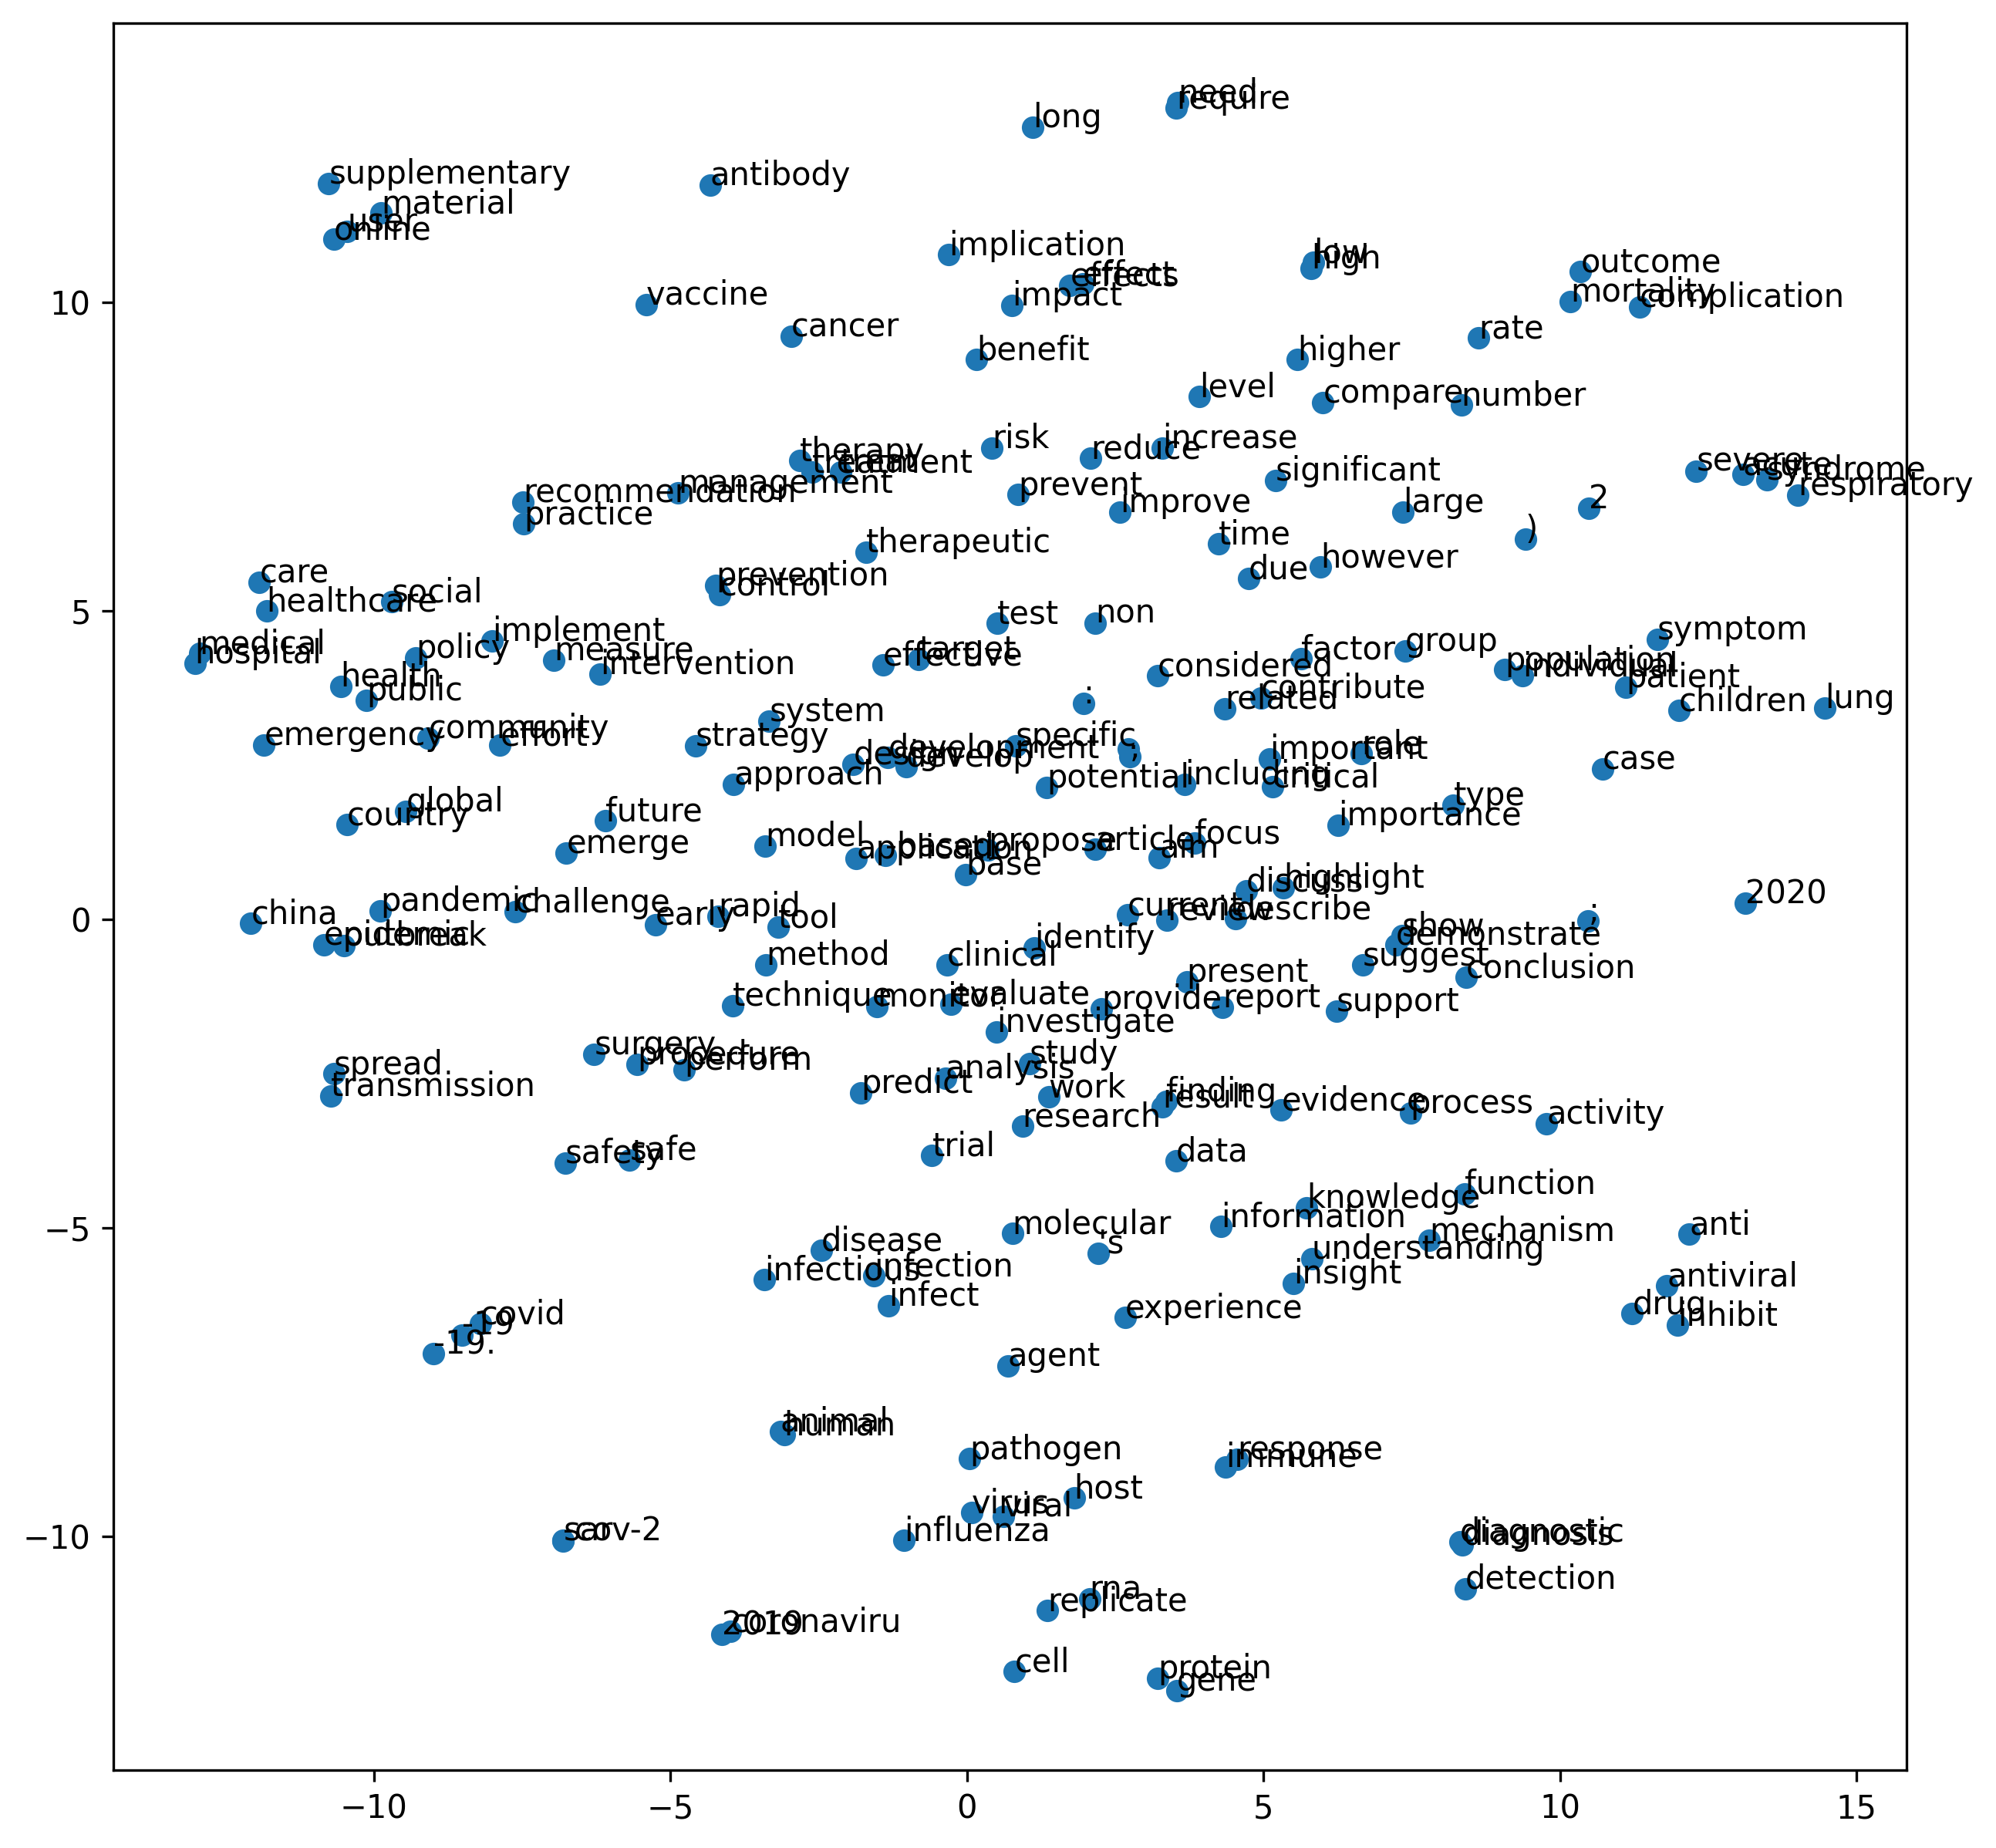

In [171]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n = 200

vocab = list(model.wv.key_to_index)
X = model.wv[vocab[:n]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
vocab_df = pd.DataFrame(X_tsne, index=vocab[:n], columns=['x', 'y'])
fig = plt.figure(figsize=(10,10),dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(vocab_df['x'], vocab_df['y'])
for word, pos in vocab_df.iterrows():
    ax.annotate(word, pos)


In [ ]:
for canidate in term_canidates:
    similar_words = model.wv.most_similar(canidate)
    expanded_query = [canidate] + [word for word, _ in similar_words]


### GLOBALE QE

Standardvariante wie z.B. auf Basis von Wikipedia.


# 1. Standard-Query an den Index für erstes Ranking

Aus dem Title des Topics, quasi wie in der Standard-Pipeline in Pyterrier.
Paper Inverse Document Frequency model (InL2)
Zuerst BM25.


In [10]:
# Create index only to retrieve the tokens from it
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
trec_covid_index_ref = build_index('trecCovid', dataset)
trec_covid_index = pt.IndexFactory.of(trec_covid_index_ref)
# display(dataset.get_topics().columns)
# display(dataset.get_topics())
# display(dataset.get_qrels())


C:\Users\timm_\AppData\Local\Temp\ipykernel_1080\1484319792.py:64: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use kwargs in constructor instead
  index_created = indexer.index(dataset.get_corpus_iter(),
cord19/trec-covid documents: 100%|██████████| 192509/192509 [01:50<00:00, 1742.14it/s]


In [11]:

title_queries = dataset.get_topics('title')
#bm25 = pt.BatchRetrieve(trec_covid_index, wmodel='BM25', num_results=10)
#res = bm25.transform(title_queries)
experiment = run_experiment(
    trec_covid_index, title_queries, dataset.get_qrels())
print(experiment)


                  name    P@5   P@10   nDCG@10      nDCG  RR(rel=2)       map
0               TF_IDF  0.692  0.682  0.612825  0.412969   0.691492  0.212390
1                 BM25  0.696  0.678  0.604724  0.410307   0.664096  0.207559
2                 InL2  0.664  0.640  0.575693  0.412668   0.661016  0.211467
3  bm25 >> bo1 >> bm25  0.712  0.674  0.606241  0.426800   0.670942  0.216934


# 2. Erstellung der Termkandidaten

## 2.1 Top-3 Dokumente

Alle Terme (ausschließlich der Stoppworte).


In [51]:
top_k_amount = 3

title_queries = dataset.get_topics('title')
bm25 = pt.BatchRetrieve(trec_covid_index, wmodel='BM25', num_results=10)
res = bm25.transform(title_queries)
sorted_results = res.sort_values(by="score", ascending=False)
top_k_docs = sorted_results[:top_k_amount]
print(top_k_docs)


    qid   docid     docno  rank      score                        query
130  14  129850  37katpp3     0  36.541817  coronavirus super spreaders
131  14  127975  p48bw6s4     1  36.263365  coronavirus super spreaders
132  14  127976  93l22ign     2  36.263365  coronavirus super spreaders


In [52]:
# FRAGE: Nehme ich hier den abstract oder muss ich den GESAMTEN Text nehmen?
tokens_df = pd.DataFrame(columns=["qid", "query"])
i = 0
for index, row in top_k_docs.iterrows():
    row = docs.loc[docs["docno"] == row.docno].iloc[0]
    #row_tokens = regex_tokenizer.tokenize(row["title"].item())
    #tokens = row_tokens + tokens
    new_line = pd.DataFrame(
        {"qid": i+1, "query": row["title"]}, index=[i])
    tokens_df = pd.concat([tokens_df, new_line])
    i += 1
tokens_df


,qid,query
0,1,A super-spreader of COVID-19 in Ningbo city in...
1,2,Significance of super spreader events in COVID-19
2,3,Significance of super spreader events in COVID-19


In [53]:

for i in range(top_k_amount):
  title_queries.iloc[i].query = tokens_df.iloc[i].query
title_queries = title_queries.iloc[:top_k_amount]
# LÄCHERLICH DAS DAS KLAPPT!

In [54]:
bm25 = pt.BatchRetrieve(trec_covid_index, wmodel='BM25')
bo1 = pt.rewrite.Bo1QueryExpansion(trec_covid_index)
pipelineQE = bm25 >> bo1 >> bm25

res = pipelineQE.transform(title_queries)
sorted_results = res.sort_values(by="score", ascending=False)
print(sorted_results)


     qid   docid     docno  rank      score  \
0      1  129850  37katpp3     0  44.179337   
1      1  152550  v034aa1m     1  43.299718   
2001   3  127976  93l22ign     1  40.524238   
1001   2  127976  93l22ign     1  40.524238   
1000   2  127975  p48bw6s4     0  40.524238   
...   ..     ...       ...   ...        ...   
2997   3   78667  n9x8k008   997   5.919823   
2998   3   43820  cd62qfui   998   5.919112   
1998   2   43820  cd62qfui   998   5.919112   
1999   2      48  tw6wusxe   999   5.918164   
2999   3      48  tw6wusxe   999   5.918164   

                                                query_0  \
0     A super-spreader of COVID-19 in Ningbo city in...   
1     A super-spreader of COVID-19 in Ningbo city in...   
2001  Significance of super spreader events in COVID-19   
1001  Significance of super spreader events in COVID-19   
1000  Significance of super spreader events in COVID-19   
...                                                 ...   
2997  Significance of 

In [183]:
bm25 = pt.BatchRetrieve(trec_covid_index, wmodel='BM25')
bo1 = pt.rewrite.Bo1QueryExpansion(trec_covid_index)
pipelineQE = bm25 >> bo1 >> bm25

title_queries = dataset.get_topics('title')
res = pipelineQE.transform(title_queries)
sorted_results = res.sort_values(by="score", ascending=False)
print(sorted_results)


      qid   docid     docno  rank      score  \
1001   10  119890  km4qijqj     1  44.506971   
1000   10  119889  po2c65nb     0  44.506971   
1002   10  189615  o9ii9fj3     2  44.230909   
31000  38  111061  09lw7d2p     0  41.133142   
31001  38  126416  zvzfgdkt     1  41.133142   
...    ..     ...       ...   ...        ...   
36995  42    1197  vjxmrmfc   995   2.226237   
36996  42  163873  gabcaqfu   996   2.225578   
36997  42  124173  m7hcyyc3   997   2.225474   
36998  42   76050  4uxwojzo   998   2.225423   
36999  42   76544  4bnje5un   999   2.221218   

                                    query_0  \
1001   coronavirus social distancing impact   
1000   coronavirus social distancing impact   
1002   coronavirus social distancing impact   
31000           covid inflammatory response   
31001           covid inflammatory response   
...                                     ...   
36995                vitamin d and covid 19   
36996                vitamin d and covid 19   


## 2.2 Terme der Referenzen

Alle Terme aus den Referenzen der 3 Dokumente (Terme der Titel).


In [17]:
import pandas as pd
metadata = pd.read_csv('~/.ir_datasets/cord19/2020-07-16/metadata.csv', low_memory=False)
metadata.columns

Index(['cord_uid', 'sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id',
       'license', 'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 's2_id'],
      dtype='object')

In [97]:
# takes docno and returns list of titles
# searches docs and metadata for doi
# if there is no doi looks for the 'title' in pubmed and takes the first result
# gets the paper by doi from semantic scholar
def get_references_titles_by_docno(docno,metadata,docs):
    current_doc_metadata = metadata.loc[metadata["cord_uid"] == docno]
    current_doc_metadata_doi = current_doc_metadata.doi.item()
    current_doc_docs_doi = docs.loc[docs["docno"] == docno].doi.item()

    if current_doc_metadata_doi is pd.NA and current_doc_docs_doi is pd.NA and current_doc_metadata_doi == "" and current_doc_docs_doi == "":
        return []

    paper = semantic_scholar.get_paper(current_doc_metadata_doi or current_doc_docs_doi)
    if not paper:
        results = pubmed.query(current_doc_metadata.title.item(), max_results=1)
        if not results:
            return []
        paper_obj = next(results)
        paper_pubmed_id = paper_obj.pubmed_id.split("\n")[0]
        paper = semantic_scholar.get_paper("PMID:" + paper_pubmed_id)

    if not paper or not paper.references:
        return []
    else:
        return list(map(lambda x:x.title, paper.references))


In [ ]:
for index,current_doc in top_k_docs.iterrows():
    titles = get_references_titles_by_docno(current_doc.docno)


## 2.3 Erweiterung mit Co-Autoren

Über die Koautoren können noch weitere Dokumente bzw. die entsprechenden Terme hinzugefügt werden. Aus Zeitgründen könnte man vielleicht auch diesen Schritt weglassen, wenn es zu viel Aufwand ist über Koautoren weitere Dokumente zu finden. Bei der Implementierung scheint ihr ja aber schon recht weit zu sein. Die "relevanten Paper der Autoren" sind einfach die Top-k Dokumente oder möglicherweise alle zusätzlichen Papers, die über die Koautorenschaft gefunden werden, gemeint. Daher ergibt sich auf der Name PSEUDO-Relevanz-Feedback, da einfach angenommen wird, dass die Top-Treffer alle relevant sind.

Referenzen = Quellen (Alle im Paper direkt zitierten Quellen)

Paper der Co-Autoren = Alle Autoren des Papers und deren Paper



In [ ]:
author_dict = {}
for id, authors in zip(metadata['cord_uid'], metadata['authors']):
    author_dict[id] = authors

for index,current_doc in top_k_docs.iterrows():
    current_doc_authors_string = metadata.loc[metadata["cord_uid"] == current_doc.docno].authors.item()
    current_doc_authors = current_doc_authors_string.split('; ')
    for author in current_doc_authors:
            # ATTENTION Might need sleep(10) or sth because of API restrictions
            time.sleep(5)
            semantic_scholar_author_results = semantic_scholar.search_author(author)
            if semantic_scholar_author_results:
                # Relevance? How to asses the relevance?
                # Build a new index with all the papers and assess relevance again
                indexref_author_papers = build_index(semantic_scholar_author_results[0].papers)
                ranked_author_papers = pt.BatchRetrieve(indexref_author_papers, wmodel='BM25')
                print(ranked_author_papers.search(current_doc.query))





In [196]:
print(current_doc_authors_string)
#print(semantic_scholar.search_author('Lin, Jie'))
results = pubmed.query('Lin, Jie', max_results=500)
first_three = list(map(lambda x:x.toDict(), islice(results, 3)))
print(first_three[0]['title'])


Lin, Jie; Yan, Kun; Zhang, Jingfeng; Cai, Ting; Zheng, Jianjun


Oligomeric Proanthocyanidins Confer Cold Tolerance in Rice through Maintaining Energy Homeostasis.


# 2.4 Ranking aller Terms

Paper: Bo1
Top-k Terme auswählen (k selbst wählen).
Ergebnis: Potentielle Kandidaten für eine Termwerweiterung


# 2.5 Word2Vec-Modell mit Terms nachtrainieren

Über die Kosinusähnlichkeit der Embeddings der ursprünglichen Anfrageterme bestimmt ihr nun weitere Terme aus dem Word2Vec-Modell. Diese Termkandidaten werden dann wie in 2.1.4 über Bo1 o.ä. gerankt.


In [ ]:
mv_model = Word2Vec.load("data/word2vec.model")


# 2.6 Zwei Sets zusammenfügen und Top-k für QE der ursprünglichen Querry nutzen

Diese jeweils für die 50 Topics absenden.

Ergebnis: Die finalen Rankings, die dann ausgewertet werden können.
